In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using ForwardDiff
using BenchmarkTools

In [2]:
function cov_matr(smpl_tmp)
    smp_fl, w = flatview(unshaped.(smpl_tmp.v)), smpl_tmp.weight
    smp_fl = smp_fl ./ std(smp_fl, FrequencyWeights(w), 2)
    smp_fl = smp_fl .- mean(smp_fl, FrequencyWeights(w), dims=2)
    cov_m = cov(smp_fl, FrequencyWeights(w), 2)
    return cov_m
end

prior_ang = NamedTupleDist(
    θ = [10^-15 .. 10^-4 for i in 1:150],
    α = [0 .. 2*pi  for i in 1:150],
    x_alignm = [-200 .. 200 for i in 1:3],
    y_alignm = [-200 .. 200 for i in 1:3],
    σ_x = [0.001 .. 50., 0.001 .. 100., 0.001 .. 100.],
    σ_y = [0.001 .. 50., 0.001 .. 100., 0.001 .. 100.],
);

In [3]:
@load "../../data/sampling_results/Benchmark-9/mcmc-summary-data-150.jld" summary_data

1-element Array{Symbol,1}:
 :summary_data

In [4]:
smpl_tmp = bat_read("../../data/sampling_results/Benchmark-9/samples-1-150.hdf5")
samples = varshape(prior_ang).(smpl_tmp)
ind_1 = 1:150;

# Plots: 

## Azimutal angle: 

In [5]:
function construct_hist(ind_tmp, samples_tmp)
    hist_array_tmp = Histogram[]
    for (ind, val) in enumerate(ind_tmp)
        smpl_x = []
        for smpl in samples_tmp.v
            push!(smpl_x, smpl.α[ind])
        end
        hist_tmp = fit(Histogram, smpl_x, FrequencyWeights(samples_tmp.weight), range(0, stop=2*pi, length=150))
        hist_tmp = normalize(hist_tmp, mode=:pdf)
        push!(hist_array_tmp, hist_tmp)
    end 
    return hist_array_tmp
end

construct_hist (generic function with 1 method)

In [6]:
hist_array = Histogram[]

append!(hist_array, construct_hist(ind_1, samples));

In [7]:
charge_n = summary_data.ev_charge ./ maximum(summary_data.ev_charge);
charge_n[sortperm(charge_n)] .= 1:length(charge_n);
charge_n = charge_n ./ maximum(charge_n);

In [8]:
event_ind = summary_data.ev_index ./ maximum(summary_data.ev_index);

event_ind[sortperm(event_ind)] .= 1:length(event_ind);
event_ind = event_ind ./ maximum(event_ind);

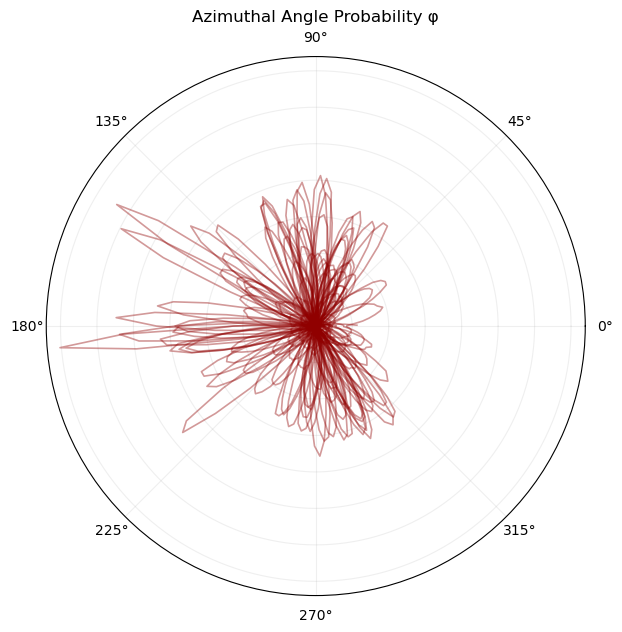

PyObject Text(0.5, 1.05, 'Azimuthal Angle Probability φ')

In [9]:
fig = figure(figsize=(7,7))

ax = PyPlot.axes(polar="true") # Create a polar axis

for i in eachindex(hist_array)
    ax.plot(midpoints(hist_array[i].edges[1]), 
        hist_array[i].weights, 
        lw=1.2,  "o-", 
        color= plt.cm.hot_r(0.8), #"k", #plt.cm.hot_r(charge_n[i]), 
        alpha=0.4, 
        marker="None") 
end


ax.grid(alpha=0.2)
ax.set_yticklabels([])
ax.set_title("Azimuthal Angle Probability φ")

## Polar angle:

In [10]:
function construct_log_hist(ind_tmp, samples_tmp)
    hist_array_tmp = Histogram[]
    for ind in 1:150
        smpl_x = []
        for smpl in samples_tmp.v
            push!(smpl_x, log.(smpl.θ[ind]))
        end
        hist_tmp = fit(Histogram, smpl_x, FrequencyWeights(samples_tmp.weight), range(-19, stop=-8, length=150))
        hist_tmp = normalize(hist_tmp, mode=:pdf)
        push!(hist_array_tmp, hist_tmp)
    end 
    return hist_array_tmp
end

construct_log_hist (generic function with 1 method)

In [11]:
hist_array = Histogram[]

append!(hist_array, construct_log_hist(ind_1, samples));

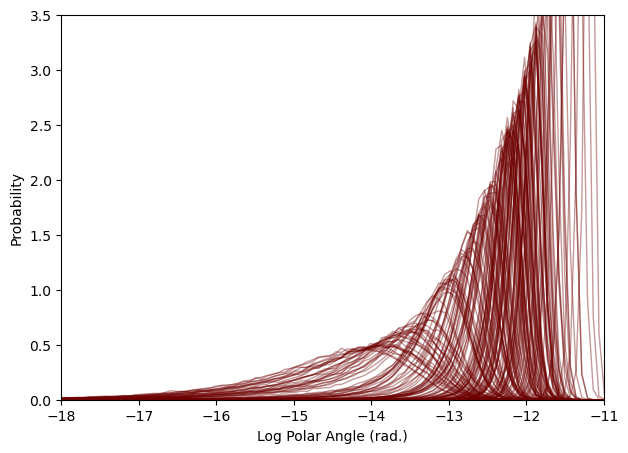

PyObject Text(24.000000000000007, 0.5, 'Probability')

In [12]:
fig, ax= plt.subplots(1,1, figsize=(7,5), )

for i in eachindex(hist_array)
    ax.plot(midpoints(hist_array[i].edges[1]), 
        hist_array[i].weights, 
        lw=1.0,  "o-", 
        color= plt.cm.hot_r(0.85),  #"k",  #plt.cm.hot_r(charge_n[i]), 
        alpha=0.4, 
        marker="None")
end
ax.set_xlim(-18, -11)

ax.set_ylim(0, 3.5)
ax.set_xlabel("Log Polar Angle (rad.)")
ax.set_ylabel("Probability")


## Waist Position:

In [13]:
function predict_position(x0, y0, θ, α, s)
    x_expected = x0 .+ cos(α).*θ.*s.*10^6
    y_expected = y0 .+ sin(α).*θ.*s.*10^6
    return (x_expected, y_expected)
end

predict_position (generic function with 1 method)

In [14]:
function construct_waist_hist(ind_run, samples_tmp, init_data)
    array_tmp = []
    
    for (ind, val) in enumerate(ind_run)
        x_init = summary_data.μx_align[val][1]
        y_init = summary_data.μy_align[val][1]
        
        x_position = Float64[]
        y_position = Float64[]
        
        for smpl in samples_tmp.v
            pred_x, pred_y = predict_position(x_init, y_init, smpl.θ[ind], smpl.α[ind], 2.9)
            push!(x_position, pred_x)
            push!(y_position, pred_y)
        end
        
        x_mean = mean(x_position, FrequencyWeights(samples_tmp.weight))
        y_mean = mean(y_position, FrequencyWeights(samples_tmp.weight))
        
        x_std = std(x_position, FrequencyWeights(samples_tmp.weight))
        y_std = std(y_position, FrequencyWeights(samples_tmp.weight))
        
        hist_tmp = fit(Histogram, (x_position,y_position), FrequencyWeights(samples_tmp.weight), nbins=30) 
#         hist_tmp = normalize(hist_tmp, mode=:pdf)
        
        push!(array_tmp, (μ=[x_mean, y_mean], σ=[x_std, y_std], hist=hist_tmp))
    end 
    return array_tmp
end

construct_waist_hist (generic function with 1 method)

In [15]:
hist_array = []

append!(hist_array, construct_waist_hist(ind_1, samples, summary_data));


In [16]:
μ_x = [i.μ[1] for i in hist_array]
μ_y = [i.μ[2] for i in hist_array]

σ_x = [i.σ[1] for i in hist_array]
σ_y = [i.σ[2] for i in hist_array]

μ_x = μ_x .- minimum(μ_x)
μ_y = μ_y .- minimum(μ_y);

In [17]:
std(μ_y)

21.652475119298014

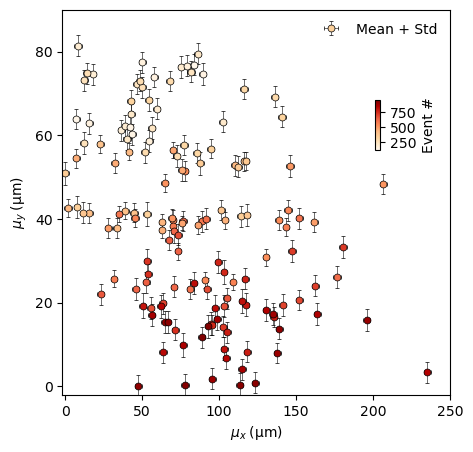

(-2.0, 90.0)

In [18]:
fig, ax= plt.subplots(1,1, figsize=(5,5), )

label = "Mean + Std"
for i in eachindex(hist_array)
    
    ax.errorbar(μ_x[i], μ_y[i], xerr=σ_x[i], yerr=σ_y[i], 
        mfc=plt.cm.OrRd(event_ind[i]), #red
        fmt="o", 
        markersize = 5, 
        markeredgecolor = "k", 
        markeredgewidth=0.5, 
        capsize=1.5, 
        ecolor="k", elinewidth=0.4, label=label)
    label=""
end

cb = ax.scatter(event_ind, event_ind, s=0.0, c=summary_data.ev_index, cmap="OrRd")
ax_ins_3 = fig.add_axes([0.75,0.6,0.01,0.1])
fig.colorbar(cb, spacing="proportional", label="Event #", cax=ax_ins_3)

ax.set_xlabel(L"\mu_x \; \mathrm{(\mu m)}")
ax.set_ylabel(L"\mu_y \; \mathrm{(\mu m)}")

ax.legend(loc="upper right", framealpha=0.0)

ax.set_xlim(-2,250)
ax.set_ylim(-2,90)

# Time Correction: 

In [19]:
include("../utill.jl")

plot_projections (generic function with 1 method)

In [20]:
data_tmp = (μ_x=μ_x, μ_y=μ_y, ind=summary_data.ev_index);

In [21]:
prior_test = NamedTupleDist(
    x_init = -100. .. 100., 
    y_init = -100. .. 100., 
    x_α = -10^2 .. 10^2,
    y_α = -10^2 .. 10^2,
    x_σ = 1 .. 50,
    y_σ = 1 .. 50,
);

In [22]:
function log_lik(; d = data_tmp)
    
    return p -> begin   
        
        ll = 0.0
    
        x_pred = p.x_init .+ p.x_α .* d.ind
        y_pred = p.y_init .+ p.y_α .* d.ind
        
        ll += sum(logpdf.(Normal.(x_pred, p.x_σ), d.μ_x))
        ll += sum(logpdf.(Normal.(y_pred, p.y_σ), d.μ_y))

        return LogDVal(ll)
    end
        
end

log_likelihood = log_lik()

#57 (generic function with 1 method)

In [23]:
par_tmp = rand(prior_test)

log_likelihood(par_tmp)

LogDVal{Float64}(-2.769834468268224e9)

In [24]:
posterior = PosteriorDensity(log_likelihood, prior_test)
posterior_is = bat_transform(PriorToGaussian(), posterior, PriorSubstitution()).result;

In [25]:
iterations = 10000
iter_warmup = 500
chains = 4;

In [26]:
metric = BAT.DiagEuclideanMetric()
integrator = BAT.LeapfrogIntegrator()
proposal = BAT.NUTS(:MultinomialTS, :ClassicNoUTurn)
adaptor = BAT.StanHMCAdaptor(0.8, iter_warmup)

hmc_sampler = HamiltonianMC(metric, ForwardDiff, integrator, proposal, adaptor);

In [27]:
@time samples_is = bat_sample(posterior_is, iterations, MCMCSampling(sampler = hmc_sampler, nchains = chains));

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:63
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:185
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:38
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 4 tuned, 4 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC tuning of 4 chains successful after 1 cycle(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:76


167.426919 seconds (739.61 M allocations: 445.183 GiB, 20.64% gc time)


In [28]:
samples = samples_is.result;

In [29]:
trafo_is = trafoof(posterior_is.likelihood)
samples = inv(trafo_is).(samples);

In [30]:
sz = size(flatview(unshaped.(samples.v)))

(6, 10000)

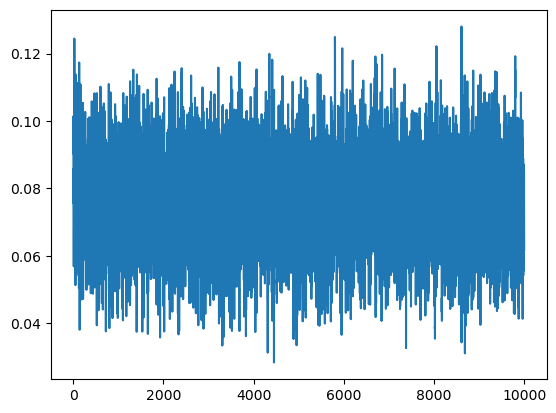

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd9e00abbe0>

In [31]:
plot(flatview(unshaped.(samples.v))[3,:])

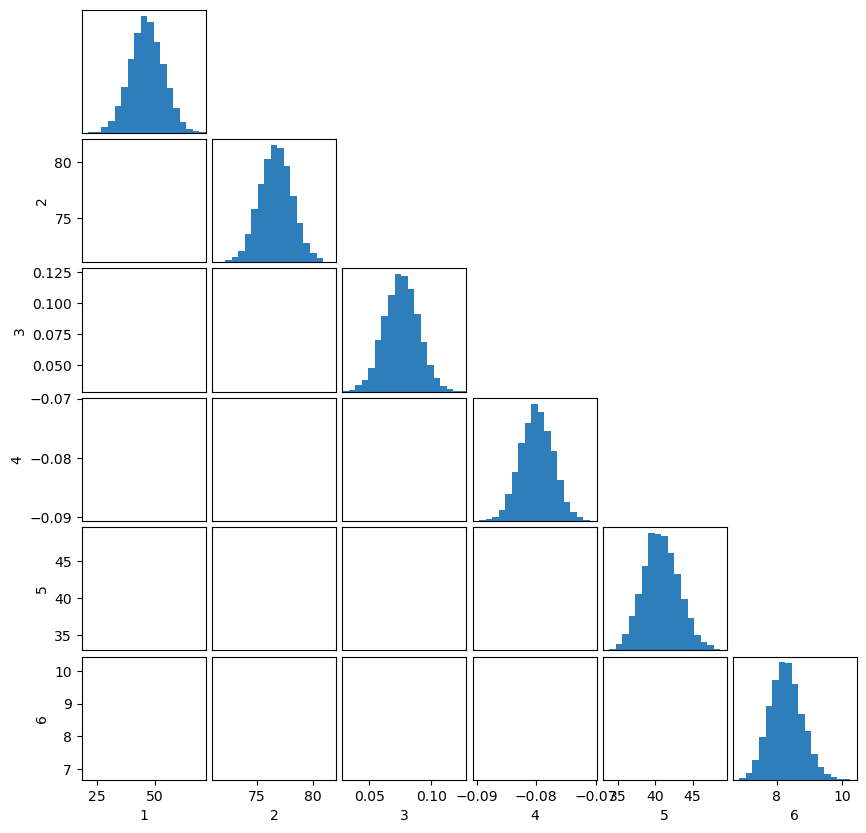

In [32]:
dims = 1:6
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.001, 1,]
figsize = (10,10)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [33]:
mean_par = mean(samples)[1]

(x_init = 46.58575923859514, y_init = 76.72300325409752, x_α = 0.07587578578424446, y_α = -0.07990696183780592, x_σ = 40.80438156800195, y_σ = 8.291939884788432)

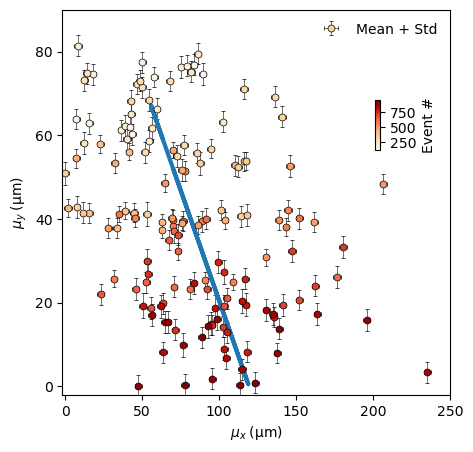

(-2.0, 90.0)

In [34]:
fig, ax= plt.subplots(1,1, figsize=(5,5), )

label = "Mean + Std"
for i in eachindex(hist_array)
    
    ax.errorbar(μ_x[i], μ_y[i], xerr=σ_x[i], yerr=σ_y[i], 
        mfc=plt.cm.OrRd(event_ind[i]), #red
        fmt="o", 
        markersize = 5, 
        markeredgecolor = "k", 
        markeredgewidth=0.5, 
        capsize=1.5, 
        ecolor="k", elinewidth=0.4, label=label)
    label=""
end

ev_ind_test = 1:1000


x = mean_par.x_init .+ mean_par.x_α .* data_tmp.ind
y = mean_par.y_init .+ mean_par.y_α .* data_tmp.ind

ax.plot(x, y, color="C0", lw=3)

cb = ax.scatter(event_ind, event_ind, s=0.0, c=summary_data.ev_index, cmap="OrRd")
ax_ins_3 = fig.add_axes([0.75,0.6,0.01,0.1])
fig.colorbar(cb, spacing="proportional", label="Event #", cax=ax_ins_3)

ax.set_xlabel(L"\mu_x \; \mathrm{(\mu m)}")
ax.set_ylabel(L"\mu_y \; \mathrm{(\mu m)}")

ax.legend(loc="upper right", framealpha=0.0)

ax.set_xlim(-2,250)
ax.set_ylim(-2,90)

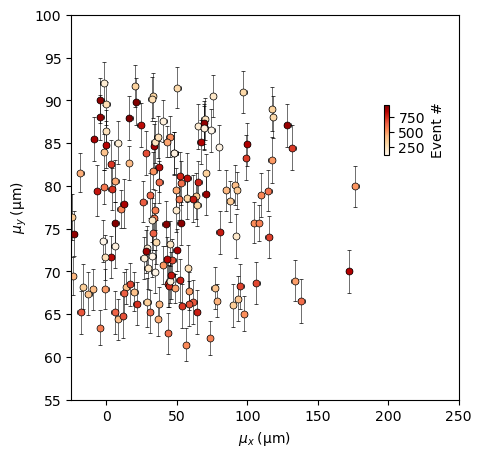

No handles with labels found to put in legend.


(55.0, 100.0)

In [35]:
fig, ax= plt.subplots(1,1, figsize=(5,5), )

x = mean_par.x_init .+ mean_par.x_α .* data_tmp.ind
y = mean_par.y_init .+ mean_par.y_α .* data_tmp.ind

# ax.plot(x, y, color="C0", lw=3)

x_tmpp = []
y_tmpp = []

for i in eachindex(hist_array)
    
    x_tmp = mean_par.x_α .* summary_data.ev_index[i]
    y_tmp = mean_par.y_α .* summary_data.ev_index[i]
    
    x_tmp = μ_x[i] - x_tmp
    y_tmp = μ_y[i] - y_tmp
    
    push!(x_tmpp, x_tmp)
    push!(y_tmpp, y_tmp)
    
    ax.errorbar(x_tmp, y_tmp, xerr=σ_x[i], yerr=σ_y[i], 
        mfc=plt.cm.OrRd(event_ind[i]), #red
        fmt="o", 
        markersize = 5, 
        markeredgecolor = "k", 
        markeredgewidth=0.5, 
        capsize=1.5, 
        ecolor="k", elinewidth=0.4, label=label)
    label=""
    
end

cb = ax.scatter(event_ind, event_ind, s=0.0, c=summary_data.ev_index, cmap="OrRd")
ax_ins_3 = fig.add_axes([0.75,0.6,0.01,0.1])
fig.colorbar(cb, spacing="proportional", label="Event #", cax=ax_ins_3)

ax.set_xlabel(L"\mu_x \; \mathrm{(\mu m)}")
ax.set_ylabel(L"\mu_y \; \mathrm{(\mu m)}")

ax.legend(loc="upper right", framealpha=0.0)

ax.set_xlim(-25,250)
ax.set_ylim(55,100)

In [36]:
std(x_tmpp)

40.32902289905977

In [37]:
std(y_tmpp)

8.183726036784861